In [16]:
import scipy
import sklearn
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [17]:
from backtester.dataSource.csv_data_source import CsvDataSource

In [18]:
# Load the data
cachedFolderName = '/data/'
dataSetId = 'trainingData1'
startDate = '2017/01/06'
endDate = '2017/02/09'
instrumentIds = ['MQK']
downloadUrl = 'https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data'

ds = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             startDateStr=startDate,
                             endDateStr=endDate,
                             liveUpdates=False,
                             pad=True)


Processing data for stock: MQK


In [4]:
#Loading our data
def loadData(ds, id):
    data = ds._bookDataByInstrument[id].getBookData()

    data['Stock Price'] =  (data['stockTopBidPrice'] +\
                           data['stockTopAskPrice']) / 2.0
    data['Future Price'] = (data['futureTopBidPrice'] +\
                           data['futureTopAskPrice']) / 2.0
    data['Y(Target)'] = data['basis'].shift(-5)
    del data['benchmark_score']
    del data['FairValue']
    return data

data = loadData(ds,instrumentIds[0])

In [5]:
# Training Data
dataSetId =  'trainingData1'
ds_training = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)

training_data = loadData(ds_training, instrumentIds[0])

# Validation Data
dataSetId =  'trainingData2'
ds_validation = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)
validation_data = loadData(ds_validation, instrumentIds[0])

# Test Data
dataSetId =  'trainingData3'
ds_test = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)
out_of_sample_test_data = loadData(ds_test, instrumentIds[0])

Processing data for stock: MQK
Processing data for stock: MQK
Processing data for stock: MQK


In [6]:
def prepareData(data, period):
    data['Y(Target)'] = data['basis'].rolling(period).mean().shift(-period)
    if 'FairValue' in data.columns:
        del data['FairValue']
    data.dropna(inplace=True)

period = 5
prepareData(training_data, period)
prepareData(validation_data, period)
prepareData(out_of_sample_test_data, period)

In [7]:
def difference(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0)

def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

In [8]:
def create_features_again(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [])
    
    basis_X['mom10'] = difference(data['basis'],11)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
    basis_X['emabasis5'] = ewm(data['basis'],5)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']

    basis_X['totalaskvolratio'] = (data['stockTotalAskVol']-data['futureTotalAskVol'])/100000
    basis_X['totalbidvolratio'] = (data['stockTotalBidVol']-data['futureTotalBidVol'])/100000
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

In [9]:
basis_X_test, basis_y_test = create_features_again(validation_data)
basis_X_train, basis_y_train = create_features_again(training_data)

Any null data in y: False, X: False
Length y: 6499, X: 6499
Any null data in y: False, X: False
Length y: 8737, X: 8737


In [11]:
X_train = np.expand_dims(basis_X_train, axis=2)

In [19]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Layer
import tensorflow as tf

In [41]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return (embedded_words + embedded_indices)[0]

In [42]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(7,
                                            7, 7)
model_cnn = keras.models.Sequential()
model_cnn.add(keras.layers.InputLayer(input_shape=[7, 1]))
model_cnn.add(PositionEmbeddingFixedWeights(1, 7, 1))
for dilation_rate in (1, 2, 4):
    model_cnn.add(
      keras.layers.Conv1D(filters=4,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model_cnn.add(keras.layers.Conv1D(filters=2, kernel_size=1))
#model_cnn.add(keras.layers.MaxPooling1D(pool_size=2))
#model_cnn.add(keras.layers.Flatten())
#model_cnn.add(keras.layers.Dense(1))
model_cnn.compile(optimizer='adam', loss='mae')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
position_embedding_fixed_wei (None, 7, None, 1)        8         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 7, None, 4)        12        
_________________________________________________________________
conv1d_47 (Conv1D)           (None, None, None, 4)     36        
_________________________________________________________________
conv1d_48 (Conv1D)           (None, None, None, 4)     36        
_________________________________________________________________
conv1d_49 (Conv1D)           (None, None, None, 2)     10        
Total params: 102
Trainable params: 94
Non-trainable params: 8
_________________________________________________________________


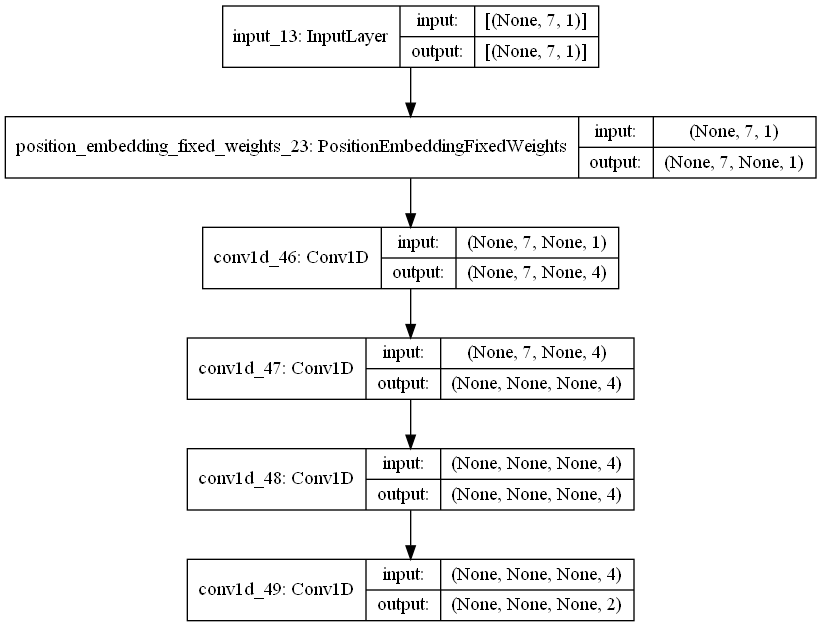

In [40]:
model_cnn.summary()
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [15]:
history = model_cnn.fit(
    X_train,
    basis_y_train,
    epochs=10,
    verbose=1)

Epoch 1/10
274/274 [==============================] - 1s 3ms/step - loss: 0.1275
Epoch 2/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1272
Epoch 3/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1277
Epoch 4/10
274/274 [==============================] - 1s 3ms/step - loss: 0.1273
Epoch 5/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1261
Epoch 6/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1275
Epoch 7/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1259
Epoch 8/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1257
Epoch 9/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1260
Epoch 10/10
274/274 [==============================] - 1s 2ms/step - loss: 0.1253
